# Assignment 3 - Sparse Matrices

## Student Number: 19008330

Final Grade: 25/30 (83.3%)

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import numba
import scipy
from scipy.linalg import block_diag
from timeit import timeit
from scipy.sparse.linalg import LinearOperator, gmres, cg
from scipy.sparse import coo_matrix,csc_matrix, csr_matrix, dia_matrix, dok_matrix, lil_matrix, diags
from time import time

## Part 1: Implementing CSR Matrix

### 1.1 Implementing ``__init__``, ``__add__`` and ``matvec``. 

In [229]:
class CSRMatrix(LinearOperator):
  def __init__(self, coo_matrix):
    # coo_matrix structure 
    self.shape = coo_matrix.shape
    self.dtype = coo_matrix.dtype
    coo_rows = coo_matrix.row
    coo_cols = coo_matrix.col
    coo_data = coo_matrix.data
    # csr_matrix structure
    self.data, self.indices = [],[]
    m =  self.shape[0]
    n = len(coo_rows)
    # coo_data = csr_data  :  coo_cols = csr_indices
    for i in range(m):
      for j in range(n):
        if i == coo_rows[j]:
          self.data.append(coo_data[j]) 
          self.indices.append(coo_cols[j]) 
    
    # Need robust sequence to convert coo_rows to csr_indptr
    h = coo_rows
    o = len(self.data)
    self.indptr = np.zeros(n+2,dtype = np.int64) # coo_rows is now list subscriptable
    for j in range(o):
        #csr_indptr must be one length greater than coo_rows
        self.indptr[h[j]+1] += 1
    for k in range(n+1):
        self.indptr[k+1] += self.indptr[k]
  
  def __add__(self, other):
      assert self.shape == other.shape
      add_data, add_indices, add_indptr = [],[],[]
      add_shape = self.shape
      
      k = 0 # Counter to iterate over
      for i in range(self.shape[0]): 
        #csr_indptr array always one length greater than shape
        add_indptr.append(k)
        self_start = self.indptr[i]
        self_end = self.indptr[i+1] 
        other_start = other.indptr[i]
        other_end = other.indptr[i+1]
        for j in range(self_start,self_end): # All self.data is within this range
          add_data.append(self.data[j])
          add_indices.append(self.indices[j])
          k+=1 
        for m in range(other_start,other_end): # All other.data is within this range
          add_data.append(other.data[m])
          add_indices.append(other.indices[m])
          k+=1
        
      add_indptr.append(k)
      
      return csr_matrix((add_data,add_indices,add_indptr),shape = add_shape)
            
  def _matvec(self, vector):
      # Ensuring matrix-vector multiplication is valid
      assert self.shape[1] == vector.shape[0]
      m, n = self.shape
      b = np.zeros(m, dtype = self.dtype) 
      for i in range(m):
          # i is the row index
          col_start = self.indptr[i]
          col_end = self.indptr[i+1]
          for j in range(col_start, col_end): # j is the column index
              b[i] += self.data[j] * vector[self.indices[j]]
  
      return b

### 1.2 Testing ``__add__`` and ``matvec`` are the same. 

The function runs for the following two cells illustrating that ``__add__`` and ``_matvec`` are correct

In [230]:
def add_sparse(A,B):
  coo_A = coo_matrix(A)
  A1 = CSRMatrix(coo_A)
  B1 = csr_matrix(B)
  # the data is added in csr_format
  add = A1.__add__(B1)

  # converting csr values to matrix
  return add.toarray()

def mv_sparse(A,v):
    return A._matvec(v)

def mv_dense(A,v):
    return A @ v



In [231]:
for n in range(0,110,10):
  A = scipy.sparse.random(n,n,0.2)
  B = scipy.sparse.random(n,n,0.2)
  add1 = add_sparse(A,B) # class addition of sparse matrices
  add2 = csr_matrix(A+B).toarray() # scipy addition of sparse matrices
  assert np.allclose(add1,add2)

In [232]:
for n in range(2,110,10):
  A = scipy.sparse.random(n,n,0.2)
  v = np.random.rand(n)
  A2 = CSRMatrix(A)
  A3 = A.toarray()  
  mvm1 = mv_sparse(A2,v)
  mvm2 = mv_dense(A3,v)
  assert np.allclose(mvm1,mvm2)

### 1.3 Measuring the Time to perform a ``matvec`` product and required plots.


In [216]:
def matvec_time(operator,runs,N):
  def op_time(operator,A,v,runs):
    assign = {'mv_dense': mv_dense, 'mv_sparse': mv_sparse, 'A': A , 'v':v, 
       'A2': A2, 'A3': A3}
    return timeit(lambda: operator(A,v), number = runs, globals = assign)
  
  output = []
  for n in N:
    A = scipy.sparse.random(n,n,0.2)
    A2 = CSRMatrix(A)
    A3 = A.toarray()
    v = np.random.rand(n)

    if operator == mv_sparse:
      if runs <= 0:
        raise ValueError("Input needs to be a positive integer")
      if runs == 1:
        output.append(op_time(operator,A2,v,runs))
      if runs > 1:
        output.append(op_time(operator,A2,v,runs)/runs)
      
    if operator == mv_dense:
      if runs <= 0:
        raise ValueError("Input needs to be a positive integer")
      if runs == 1:
          output.append(op_time(operator,A3,v,runs))
      if runs > 1:
        output.append(op_time(operator,A3,v,runs)/runs)
  
  return output


In [217]:
dimes = N = range(2,627,25)
ts = matvec_time(mv_sparse,10,N)
td = matvec_time(mv_dense,10,N)

Text(0.5, 1.0, 'Figure 1a: Runtime of Matrix-Vector Product for dimension $n$')

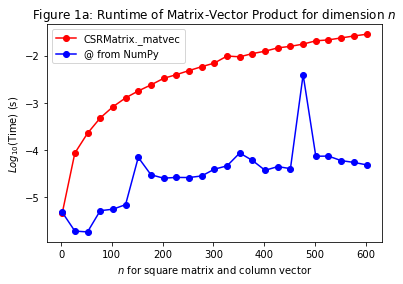

In [228]:
plt.plot(dimes, np.log10(ts), "r", marker = "o")
plt.plot(dimes, np.log10(td), "b", marker = "o")
plt.xlabel("$n$ for square matrix and column vector", size = "10")
plt.ylabel("$Log_{10}$(Time) (s)",size = "10")
plt.legend(["CSRMatrix._matvec", "@ from NumPy"])
plt.title("Figure 1a: Runtime of Matrix-Vector Product for dimension $n$")

**Note:** I only performed matrix vector products up to $ n = 600$, When I tried to reach because converting a coo_matrix with dimensions closer $n = 1000$ takes a considerable amount of time. I was not able to compute ``CSRMatrix`` for a sparse $1000 \times 1000$ matrix within 30 mins.

**Comments:** As the dimensions $n$ increase for the matrix and vector, one can see that the ``CSRMatrix._matvec`` runtime drastically increases from less than $10^{-5}$ seconds to $10^{-2}$ seconds. The ``@`` function from numpy increases at a slower rate for matrix vector multiplication (MVM), staying below $10^{-4}$ for all $n$ with the exception of $n = 477$. 

Despite the sparse format and efficiency of MVM using csr matrices. The use of two for loops means MVM is done element by element which will add to the computation time. Furthremore ``@`` is highly optimised using Basic Linear algebra Subprograms (BLAS) libraries and also performs MVM using the same sparse matrix A used in within ``CSRMatrix._matvec`` but in array form. It should be noted the ``CSRMatrix._matvec`` performs very fast runtimes, even faster than the MVM performed within the Class 1 exercises for a dense matrix which is what we would expect.




### 1.4 Using gmres and cg sparse solvers for CSR matrix problems

cg and gmres sparse solvers can only really be utilised for symmetric positive definite matrices, hence I've utilised the code from the HPC lecture notes and computed the symmetric matrix within my CSRMatrix class.

In [234]:
N =  np.arange(2,1027,25)
gmres_sol = []
cg_sol = []
# Deviation between the two solutions
for n in N:
    data = [2.1*np.ones(n), -1.*np.ones(n - 1), -1.*np.ones(n - 1)]
    offsets = [0, 1, -1]
    A = diags(data, offsets=offsets, shape=(n,n), format = 'coo')
    B = CSRMatrix(A)
    v = np.random.rand(n)
    s1,_ = gmres(B,v)
    s2,_ = cg(B,v)
    gmres_sol.append(s1)
    cg_sol.append(s2)
    

Text(0.5, 1.0, 'Figure 1b: Maximum Error between CG and GMRES Solutions for $n$ dimensions ')

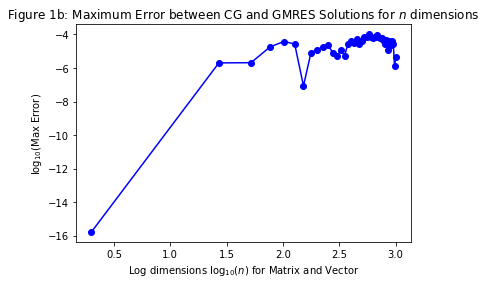

In [236]:
x = gmres_sol
y = cg_sol
devs = []
for i in range(len(x)):
    deviation = np.abs(y[i]-x[i])
    max_error = np.max(deviation[i])
    devs.append(max_error)



plt.plot(np.log10(N),np.log10(devs),"b", marker = "o")
plt.xlabel("Log dimensions $\log_{10}(n)$ for Matrix and Vector", size = "10")
plt.ylabel("$\log_{10}$(Max Error) ",size = "10")
plt.title("Figure 1b: Maximum Error between CG and GMRES Solutions for $n$ dimensions ")


### 1.5 Comments

For small matrices and vectors ($n<31$), the maximum error between solutions determined by GMRES and cg sparse solvers is incredible low, yielding errors $\epsilon < 10^{-5}$, which is incredibly impressive and indicates a very high degree of accuracy. For larger matrices and vectors of dimensions $n = 31$ to $n = 1000$, the error increases to around $10^{-6} < \epsilon < 10^{-4}$, which is quite impressive for $n = 1000$. 

CG and GMRES sparse solvers help find solutions for the the vector $x$ in the linear equation $Ax= b$ where $A$ is the matrix.The reason for the difference in solutions is how errors and residuals are calculated in CG and GMRES respectively. 

GMRES minimises the residuals and requires orthogonality with the Krylov subspace  
$$\mathcal{K}_m(A,b) := \mathrm{span}(b, Ab, ... , A^{m-1}b)$$ 

such that $r_m \perp A\mathcal{K}_m$

CG minimises the error between each point $x_i$ and $x$ (the actual solution) such that the error is orthogonal to the direction of each point $e_i^{T}d_i = 0$ where $e_i = x_i - x^{*}$ and $d_i = - \nabla f(x_i)$. The CG method, one requires the m-th residual to orthogonal to the Krylov subspace component alone ($r_m \perp K_m$). The difference between the miniminal residuals of GMRES being the matrix $A$ in the orthogonality condition. This could explain why CG has significantly faster convergence as well.


# Part 2: Implementing a custom matrix

### 2.1 Implementing a Scipy ``LinearOperator`` for matrices in custom matrix form





In [224]:
class CustomMatrix(LinearOperator):
 
    def __init__(self,n):

      D = np.random.rand(n,n)
      T = np.random.rand(n,2)
      W = np.random.rand(2,n)

      self.shape = (2*n, 2*n)
      self.dtype = np.float64

      diagonal = np.diag(np.diag(D)) # Generating the diagonal matrix in top left
      dense = T @ W # Generating the block matrix formed by TW in bottom right
      
      ''' The final 2n x 2n matrix is generated below using scipy.linalg.block_diag '''
      m = block_diag(diagonal,dense) 

      ''' The CSR form for data and indices can be retrieved straight away. However,
      to obtain self.indptr, I will be storing the rows of m in coo_rows format in the
      following for loops. Then converting coo_rows data to csr_indptr data. '''

      self.data = []
      self.indices = []
      coo_rows = []
    
      '''Converting matrix data to csr and coo matrix formats for top left diagonal matrix 
      from 0 to n and the bottom right block matrix from n to 2n'''

      for i in range(0,2*n): 
        for j in range(0,2*n):
          coo_rows.append(i)
          self.indices.append(j)
          self.data.append(m[i,j])      
   
      ''' Converting coo_matrix rows to csr_matrix indptr'''
      # Need robust sequence to convert coo_rows to csr_indptr
      h = coo_rows
      o = len(self.data)
      n = max(h)
      self.indptr = np.zeros(n+2,dtype = np.int64) # coo_rows is now list subscriptable
      for j in range(o):
          #csr_indptr must be one length greater than coo_rows
          self.indptr[h[j]+1] += 1
      for k in range(n+1):
          self.indptr[k+1] += self.indptr[k]
      
    def _matvec(self, vector): # This function is the same as matvec for CSRMatrix class

      ''' Using an assert statement to ensure the matrix and vector dimensions
      match so that matrix vector multiplication can take place '''
      assert self.shape[1] == vector.shape[0]

      m = self.shape[1]
      b = np.zeros(m, dtype=np.float64)

      for i in range(m):
          start = self.indptr[i]
          end = self.indptr[i+1]
          for j in range(start, end):
              b[i] += self.data[j] * vector[self.indices[j]]

      return b



I've opted to use the CSR data storing format similar to ``CSRMatrix``. Since the input of this matrix is not a coo_matrix. I can simply convert the data from the matrix straight to csr ``data`` and ``indices``. I opted to use a coo format to store rows and later convert to ``indptr`` due to added complexity. The ``_matvec`` function is the same as what was used in Part 1.

### 2.2 Create matrices where the entries on the diagonal of the top-left block and in the matrices $T$ and $W$ are random numbers for a range of values of $n$. 

As can be seen from ``CustomMatrix(LinearOperator)``, I have included the components required for the top left diagonal $n \times n$ matrix as well as the tall ($T$) and wide ($W$) matrices within the ``__init__`` function inside the class. This is beneficial as the only input required for this class is the number of dimensions $n$. 

I will again use an ``assert`` statement to ensure that the numpy ``@`` function provides the same as the ``CustomMatrix._matvec`` 



In [225]:
for n in range(1,200,5):
  v = np.random.rand(2*n)
  A = CustomMatrix(n)
  A_csr = csr_matrix((A.data,A.indices,A.indptr), shape = A.shape)
  A_class = A._matvec(v)
  A_actual = A_csr.toarray() @ v
  assert np.allclose(A_actual,A_class)



By converting ``A_csr`` to an array for the matrix $A$ with $n = 3$. The final matrix should have dimensions of $ 6 \times 6$ for which the top left $3 \times 3$ matrix should be diagonal and the bottom right $3 \times 3$ block should be dense. This is exactly what is observed hence the entries of $n$ in the class have been successful.

In [227]:
n = 3
A = CustomMatrix(n)
A_csr = csr_matrix((A.data,A.indices,A.indptr), shape = A.shape)
print(A_csr.toarray())

[[0.68317891 0.         0.         0.         0.         0.        ]
 [0.         0.69202895 0.         0.         0.         0.        ]
 [0.         0.         0.6365183  0.         0.         0.        ]
 [0.         0.         0.         0.83530341 0.3517644  1.18245205]
 [0.         0.         0.         0.25180605 0.11978114 0.39962069]
 [0.         0.         0.         0.4866267  0.23454312 0.7819002 ]]


As can be seen by the cell above, the matrix vector product from ``matvec`` in ``CustomMatrix(LinearOperator)`` and ``@`` from Numpy are the same.

### 2.3 Compute matrix-vector products for each matrix and measure the time taken to compute these.

The question is quite ambiguous. I interpret this question to ask how will various ways a matrix can be stored affect the runtime of the matrix vector product. For this reason, I will store the matrix in a COO (COOrdinate format), CSR (compressed sparse row), CSC (compressed sparse column) format using the scipy library. I will also use the following sparse matrix forms from scipy: 


1. ``dok_matrix``: Dictionary of keys based sparse matrix
2. ``lil_matrix``: Ros based list of lists sparse matrix.

I've chosen to abandon using ``dia_matrix``: DIAgonal storage sparse matrix as for higher dimensions $n$, the sparse storage method of diagonal entries became very inefficient as dimension $n$ increased.

From the numpy library, I will just utilise a simple ``np.matrix``. This will all be compared to the ``_matvec`` function from the class ``CustomMatrix``

In [13]:
def mv_cust(A,v):
  return A @ v

def mv_cmvp(A,v):
  return A._matvec(v)

def cust_matvec_time(operator,runs,N,type):
  def op_time(operator,A,v,runs):
    assign = {'mv_cust': mv_cust, 'mv_cmvp': mv_cmvp, 'A': A ,'v':v}
    return timeit(lambda: operator(A,v), number = runs, globals = assign)
  
  output = []
  for n in N:
    A = CustomMatrix(n)
    v = np.random.rand(2*n)
    # Use mv_cust
    A_csr = csr_matrix((A.data,A.indices,A.indptr), shape = A.shape)
    A_coo = coo_matrix(A_csr)
    A_csc = csc_matrix(A_csr)
    A_dok = dok_matrix(A_csr)
    A_lil = lil_matrix(A_csr)
    A_npm = np.matrix(A_csr.toarray())
    
    # use mv_mvp for Class Matrix Vector Product

    if type == 'csr':
      if runs <= 0:
        raise ValueError("Input needs to be a positive integer")
      if runs == 1:
          output.append(op_time(operator,A_csr,v,runs))
      if runs > 1:
        output.append(op_time(operator,A_csr,v,runs)/runs)
    
    if type == 'coo':
      if runs <= 0:
        raise ValueError("Input needs to be a positive integer")
      if runs == 1:
          output.append(op_time(operator,A_coo,v,runs))
      if runs > 1:
        output.append(op_time(operator,A_coo,v,runs)/runs)
    
    if type == 'csc':
      if runs <= 0:
        raise ValueError("Input needs to be a positive integer")
      if runs == 1:
          output.append(op_time(operator,A_csc,v,runs))
      if runs > 1:
        output.append(op_time(operator,A_csc,v,runs)/runs)
    
    if type == 'dok':
      if runs <= 0:
        raise ValueError("Input needs to be a positive integer")
      if runs == 1:
          output.append(op_time(operator,A_dok,v,runs))
      if runs > 1:
        output.append(op_time(operator,A_dok,v,runs)/runs)

    if type == 'lil':
      if runs <= 0:
        raise ValueError("Input needs to be a positive integer")
      if runs == 1:
          output.append(op_time(operator,A_lil,v,runs))
      if runs > 1:
        output.append(op_time(operator,A_lil,v,runs)/runs)
    
    if type == 'np':
      if runs <= 0:
        raise ValueError("Input needs to be a positive integer")
      if runs == 1:
          output.append(op_time(operator,A_npm,v,runs))
      if runs > 1:
        output.append(op_time(operator,A_npm,v,runs)/runs)
    
    if type == 'cmvp':
      if runs <= 0:
        raise ValueError("Input needs to be a positive integer")
      if runs == 1:
          output.append(op_time(operator,A,v,runs))
      if runs > 1:
        output.append(op_time(operator,A,v,runs)/runs)
    
    
  return output

In [65]:
dimes = N = range(1,850,25)
csr = cust_matvec_time(mv_cust,10,N,'csr') # CSR matrix
coo = cust_matvec_time(mv_cust,10,N,'coo') # COO matrix
csc = cust_matvec_time(mv_cust,10,N,'csc') # CSC matrix
dok = cust_matvec_time(mv_cust,10,N,'dok')# DOK matrix
lil = cust_matvec_time(mv_cust,10,N,'lil') # LIL matrix
npm = cust_matvec_time(mv_cust,10,N,'np') # Numpy Matrix
cmvp = cust_matvec_time(mv_cmvp,10,N,'cmvp') # Matvec from My CustomMatrix class

### 2.4 Make plots showing the runtime against $n$, comment (2-4 sentences) on what the plot shows and why one of the methods is faster.

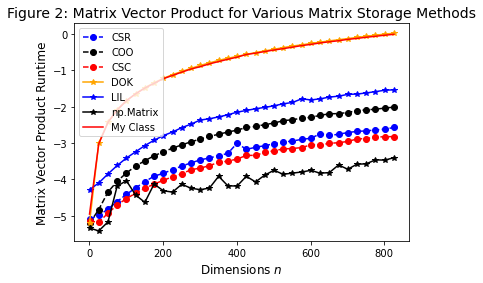

In [66]:
plt.plot(dimes,np.log10(csr), "blue", linestyle='--', marker = "o")
plt.plot(dimes,np.log10(coo), "black", linestyle='--', marker = "o")
plt.plot(dimes,np.log10(csc), "red", linestyle='--', marker = "o")
plt.plot(dimes,np.log10(dok), "orange", marker = "*")
plt.plot(dimes,np.log10(lil), "blue", marker = "*")
plt.plot(dimes,np.log10(npm), "black", marker = "*")
plt.plot(dimes,np.log10(cmvp), "red")
plt.title("Figure 2: Matrix Vector Product for Various Matrix Storage Methods", size = "14")
plt.xlabel("Dimensions $n$", size = "12")
plt.ylabel("Matrix Vector Product Runtime", size = "12")
plt.legend(["CSR", "COO", "CSC", "DOK", "LIL", "np.Matrix","My Class"])


### Comments: 

From Figure 3 above, one can observe that the best runtime for each matrix storage form is as follows:

1. Numpy Matrix Format
2. CSC Matrix
3. CSR Matrix
4. COO Matrix
5. LIL matrix
6. DOK matrix & ``CustomMatrix Class``

Numpy matrices have the best runtime for matrix-vector multiplication (MVM). Scipy utilises old C libraries which cannot compete with the highly optimised BLAS that numpy utilises [1].

Of the scipy matrix storage formats, CSC has the fastest runtime as it stores matrices in column vector form, which for MVM is much more preferable as its the "column" of the matrix being multiplied by the "row" of the vector.

CSR only falls slightly behind as CSC has the column operation advantage over rows for matrix-vector multiplication; CSR utilises compressed data storage like CSC, storing less data in the matrix, meaning it's faster than COO, LIL and DOK matrices which do not have compressed data when performing an intensive task like matrix-vector multiplication. 

The ``CustomMatrix_.matvec`` MVM is slow relative to the others as they are utilising the numpy ``@`` function whereas CustomMatrix, although utilising a CSR format still requires two for-loops which increases runtime as more computations are required.

### References:

[1] Van De Geijn, R.A. and Quintana-Ortí, E.S., 2008. The science of programming matrix computations